#  CMSC 491: Data Science Project 

### Contributors:  Joshua Standiford; Dan Kelly; Malik Jackson

This project is about analyzing weather patterns in baltimore and an increase in domestic crime.  The jupyter notebook will analyze the crime and weather data for Baltimore, MD.  From the notebook, visualizations of the crime data will be output and viewable on:

        http://hire-josh.com/projects/491proj/web/view/

## Hypothesis

### "Are domestic abuse and assault cases more likely to occur during cold or inclimate weather?"



## Null Hypothesis

### "There's no correlation between cold or inclimate weather and an increase in domestic abuse or assault"




In [2]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re

#if the csv and xlsx files are not in the same directory, use pandas.read_excel('path/to/direct/filename.txt')

weather = pandas.read_excel('../data/Baltimore_Weather_Data_3_Yr_Pnds_Adjst.xlsx')
df1 = pandas.read_csv('../data/Calls_for_Disorderly.csv')
df2 = pandas.read_csv('../data/Calls_for_Common_Assault.csv')
df3 = pandas.read_csv('../data/Calls_for_Family_Disturb.csv')
df4 = pandas.read_csv('../data/Calls_for_Behavioral_Crisis.csv')

crime  = pandas.concat([df1,df2,df3,df4])

## Pre-processing 

We start by eliminating incomplete data. We'll drop any fields with empty locations, since we need those for our heatmap

In [2]:
crime.dropna(subset = ['location'])

,callDateTime,priority,district,description,callNumber,incidentLocation,location
0,08/27/2015 12:31:00 PM,Medium,NE,DISORDERLY,P152391302,5000 LODESTONE WY,"5000 LODESTONE WY\nBALTIMORE, MD\n(39.321174, ..."
1,08/27/2015 12:43:00 PM,Medium,ND,DISORDERLY,P152391337,5100 YORK RD,"5100 YORK RD\nBALTIMORE, MD\n(39.350595, -76.6..."
2,08/27/2015 11:09:00 PM,Medium,SE,DISORDERLY,P152393662,2600 JEFFERSON ST,"2600 JEFFERSON ST\nBALTIMORE, MD\n(39.296826, ..."
3,09/01/2015 06:36:00 AM,Medium,ED,DISORDERLY,P152440510,1700 E OLIVER ST,"1700 E OLIVER ST\nBALTIMORE, MD\n(39.307481, -..."
4,07/16/2016 05:14:00 AM,Medium,CD,DISORDERLY,P161980556,1800 BLK N CALVERT ST,"1800 BLK N CALVERT ST\nBALTIMORE, MD\n(39.3100..."
6,08/27/2015 08:26:00 PM,Medium,NE,DISORDERLY,P152393030,1400 WALKER AV,"1400 WALKER AV\nBALTIMORE, MD\n(39.370561, -76..."
7,08/27/2015 11:10:00 PM,Medium,CD,DISORDERLY,P152393666,1500 PENNSYLVANIA AV,"1500 PENNSYLVANIA AV\nBALTIMORE, MD\n(39.30192..."
8,08/27/2015 12:32:00 PM,Medium,CD,DISORDERLY,P152391311,NB I 100 N AT W NORTH AV,"100 N AT W NORTH AV\nBALTIMORE, MD\n(39.311132..."
11,09/01/2015 12:26:00 AM,Medium,NW,DISORDERLY,P152440059,5500 HADDON AV,"5500 HADDON AV\nBALTIMORE, MD\n(39.337473, -76..."
12,08/27/2015 10:47:00 AM,Medium,CD,DISORDERLY,P152391003,200 N HOWARD ST,"200 N HOWARD ST\nBALTIMORE, MD\n(39.292176, -7..."


Now let's do preprocessing by stripping the long-lat coordinates from the location and throwing them into their own field.
If no coordinate data is given, we can denote that in the column with a zero

In [6]:
trueLoc = []
for locs in crime['location']:
    if type(locs) == str:
        coords = (re.findall(r'[+-]?[0-9.]+', locs))
        if len(coords) >= 2:
            trueLoc.append( [float(coords[-2]), float(coords[-1])])
        else:
            trueLoc.append(0)
    else:
        trueLoc.append(0)
        
crime['Coordinates'] = trueLoc

Now we just drop all rows where we denoted zeroes. We should only expect to find zeroes in the locations column where we
denoted them for incompletel locations, but if any other cell only has a zero, that means some additional information is missing and it's best to check and eliminate that now, then to run into errors later.

In [4]:
crime[(crime != 0).all(1)]

,callDateTime,priority,district,description,callNumber,incidentLocation,location,Coordinates
0,08/27/2015 12:31:00 PM,Medium,NE,DISORDERLY,P152391302,5000 LODESTONE WY,"5000 LODESTONE WY\nBALTIMORE, MD\n(39.321174, ...","[39.321174, -76.555046]"
1,08/27/2015 12:43:00 PM,Medium,ND,DISORDERLY,P152391337,5100 YORK RD,"5100 YORK RD\nBALTIMORE, MD\n(39.350595, -76.6...","[39.350595, -76.609722]"
2,08/27/2015 11:09:00 PM,Medium,SE,DISORDERLY,P152393662,2600 JEFFERSON ST,"2600 JEFFERSON ST\nBALTIMORE, MD\n(39.296826, ...","[39.296826, -76.58032]"
3,09/01/2015 06:36:00 AM,Medium,ED,DISORDERLY,P152440510,1700 E OLIVER ST,"1700 E OLIVER ST\nBALTIMORE, MD\n(39.307481, -...","[39.307481, -76.594228]"
4,07/16/2016 05:14:00 AM,Medium,CD,DISORDERLY,P161980556,1800 BLK N CALVERT ST,"1800 BLK N CALVERT ST\nBALTIMORE, MD\n(39.3100...","[39.310009, -76.613727]"
6,08/27/2015 08:26:00 PM,Medium,NE,DISORDERLY,P152393030,1400 WALKER AV,"1400 WALKER AV\nBALTIMORE, MD\n(39.370561, -76...","[39.370561, -76.585971]"
7,08/27/2015 11:10:00 PM,Medium,CD,DISORDERLY,P152393666,1500 PENNSYLVANIA AV,"1500 PENNSYLVANIA AV\nBALTIMORE, MD\n(39.30192...","[39.301922, -76.632707]"
8,08/27/2015 12:32:00 PM,Medium,CD,DISORDERLY,P152391311,NB I 100 N AT W NORTH AV,"100 N AT W NORTH AV\nBALTIMORE, MD\n(39.311132...","[39.311132, -76.618077]"
11,09/01/2015 12:26:00 AM,Medium,NW,DISORDERLY,P152440059,5500 HADDON AV,"5500 HADDON AV\nBALTIMORE, MD\n(39.337473, -76...","[39.337473, -76.703891]"
12,08/27/2015 10:47:00 AM,Medium,CD,DISORDERLY,P152391003,200 N HOWARD ST,"200 N HOWARD ST\nBALTIMORE, MD\n(39.292176, -7...","[39.292176, -76.619664]"


In [5]:
#Some data in the description has the same names differentiated by case. let's normalize this
names = []
for type in crime['description']:
    names.append(type.upper())
crime['description'] = names

In [6]:
#Now we'll encode our data so we have our four basic types BEHAVIORAL_CRISIS:0 COMMON ASSAULT:1 DISORDERLY:2 FAMILY_DISTURB:3  
#crime["description"] 
print crime["description"].unique()
print (crime["description"].astype('category').cat.codes).unique()

crime["description"] = crime["description"].astype('category').cat.codes

['DISORDERLY' 'COMMON ASSAULT' 'FAMILY DISTURB' 'BEHAVIOR CRISIS']
[2 1 3 0]


In [8]:
#Let's encode our dates into a proper date format in both our crime and weather pandas
dates = []
for a in  crime.as_matrix():
    dates.append( datetime.strptime(a[0].split(" ")[0] , '%m/%d/%Y'))
crime['callDateTime'] = dates

dates = []
for a in  weather.as_matrix():
    dates.append( datetime.strptime(a[0] , '%m/%d/%Y'))
weather['Date'] = dates

In [9]:
#Now, we'll sort our crimes by date in order to add in a temperature for each day
crime =  crime.sort_values(['callDateTime'], ascending=True)
crime = crime[0:469600]

In [10]:
#Find corresponding temperatures for each crime report day and add that column back in. For our correlation analysis
#we'll just use the average temperature of our dataset
avgWeather = []
indx = 0
for a in crime['callDateTime']:
    while a !=  weather['Date'][indx]:
        indx += 1
    avgWeather.append(weather['Avg_Temp'][indx])
crime['Avg_Temp'] = avgWeather

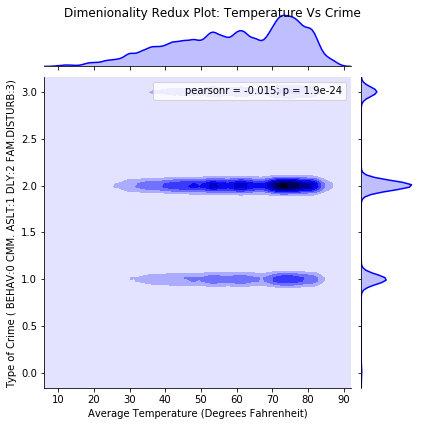

In [59]:
#Let's see  visualization of our factors now. First, we'll use a dimensionality reduction plot to see the relative amount of
#crimes per temperature
g = sns.jointplot(x=crime['Avg_Temp'], y=crime['description'], kind="kde", color="Blue")
g.set_axis_labels("Average Temperature (Degrees Fahrenheit)", "Type of Crime \
( BEHAV:0 CMM. ASLT:1 DLY:2 FAM.DISTURB:3) ")
g.fig.suptitle('Dimenionality Redux Plot: Temperature Vs Crime')
plt.show()
g.savefig("Dimenionality Plot Weather and Crime.png")

### PDA

We can see by the distribution of the graph that 2.0 is heavier, and tends to be darker towards hotter temperatures

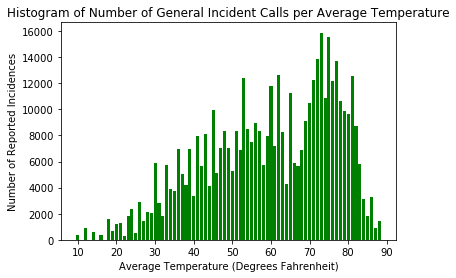

In [53]:
#Next, Let's use Histograms to get another visualiztion that will help see our correlation
#We'll start by getting counts of all incidents of crime at each  average temperature
tempBook = {}
for a in weather['Avg_Temp'].unique():
    tempBook[a] = 0
    
for a in crime['Avg_Temp']:
    tempBook[a] += 1
    
#Now, let's graph our histogram
plt.bar(tempBook.keys(), tempBook.values(),color='g')
plt.ylabel('Number of Reported Incidences')
plt.xlabel("Average Temperature (Degrees Fahrenheit)")
plt.title("Histogram of Number of General Incident Calls per Average Temperature")
plt.show()

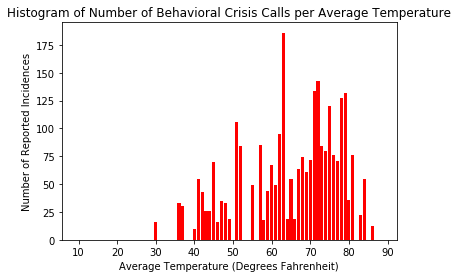

In [55]:
#Now let's see a break down of each type of crime by temperature. First, Behaviorial Crises
tempBook = {}
for a in weather['Avg_Temp'].unique():
    tempBook[a] = 0
    
for a,b in zip (crime['Avg_Temp'], crime['description']) :
    if b == 0:
        tempBook[a] += 1
    
#Now, let's graph our histogram
plt.bar(tempBook.keys(), tempBook.values(),color='r')
plt.ylabel('Number of Reported Incidences')
plt.xlabel("Average Temperature (Degrees Fahrenheit)")
plt.title("Histogram of Number of Behavioral Crisis Calls per Average Temperature")
plt.show()

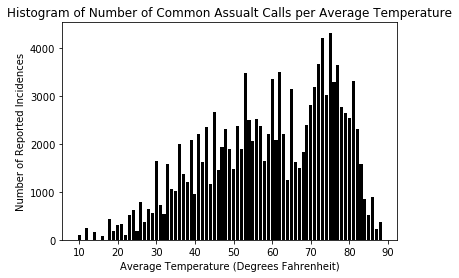

In [60]:
#Then, Common Assualt
tempBook = {}
for a in weather['Avg_Temp'].unique():
    tempBook[a] = 0
    
for a,b in zip (crime['Avg_Temp'], crime['description']) :
    if b == 1:
        tempBook[a] += 1
    
#Now, let's graph our histogram
plt.bar(tempBook.keys(), tempBook.values(),color='k') 
plt.ylabel('Number of Reported Incidences')
plt.xlabel("Average Temperature (Degrees Fahrenheit)")
plt.title("Histogram of Number of Common Assualt Calls per Average Temperature")
plt.show()

#### Correlation,

What do we see about the graph 

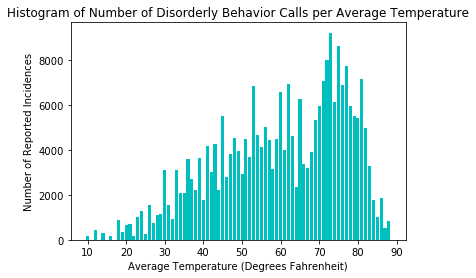

In [61]:
#Next, Disorderly Behavior
tempBook = {}
for a in weather['Avg_Temp'].unique():
    tempBook[a] = 0
    
for a,b in zip (crime['Avg_Temp'], crime['description']) :
    if b == 2:
        tempBook[a] += 1
    
#Now, let's graph our histogram
plt.bar(tempBook.keys(), tempBook.values(),color='c') 
plt.ylabel('Number of Reported Incidences')
plt.xlabel("Average Temperature (Degrees Fahrenheit)")
plt.title("Histogram of Number of Disorderly Behavior Calls per Average Temperature")
plt.show()

#### Correlation
Depicted below we can see that the graph is actually bi-modal, with a larger mean tending towards the "hotter" temperatures.

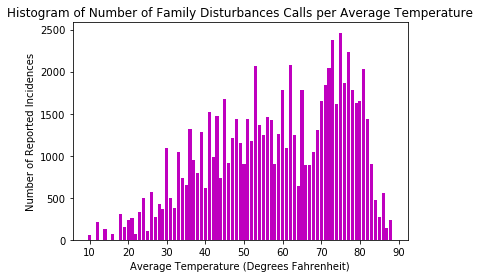

In [58]:
#Finally, Family Disturbances
tempBook = {}
for a in weather['Avg_Temp'].unique():
    tempBook[a] = 0
    
for a,b in zip (crime['Avg_Temp'], crime['description']) :
    if b == 3:
        tempBook[a] += 1
    
#Now, let's graph our histogram
plt.bar(tempBook.keys(), tempBook.values(),color='m') 
plt.ylabel('Number of Reported Incidences')
plt.xlabel("Average Temperature (Degrees Fahrenheit)")
plt.title("Histogram of Number of Family Disturbances Calls per Average Temperature")
plt.show()

# Classification 

In [9]:
#We will be importing Dr. Kalpaki's functions he created in his classification file, as well as importing sklearn packages
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier


def isOneOfMany(y):
    if y.ndim > 1 and y.shape[1] > 1:
        return True
    return False

def is_method(obj, name):
    val = False
    if hasattr(obj, name) and inspect.ismethod(getattr(obj, name)):
        val = True
    #print(obj, name, val)
    return val

def modelPredict(X_this, y_this, model):
    # y_hat, y_score, y_prob = modelPredict(X_this, y_this, model)
    y_hat = classifier.predict(X_this)
    y_score = np.zeros_like(y_this) #.fill(np.nan) 
    y_score = y_hat
    y_prob = np.zeros_like(y_this) #.fill(np.nan)
    y_prob = y_hat
    if is_method(model, 'decision_function'): 
        y_score = classifier.decision_function(X_this)
    if is_method(model, 'predict_proba'): 
        y_prob = classifier.predict_proba(X_this)
    return (y_hat, y_score, y_prob)

def classifierConfusionMatrix(y, y_hat, n_classes=2, class_labels=None, title=None, ax=None, cmap=plt.cm.Blues):
    # Construct and plot a multi-class confusion matrix; 
    # C[i,j] is the fraction of true class i predicted as class j
    
    if class_labels is None:
        class_labels = ['Class ' + str(i) for i in range(n_classes)]
        
    #Compute confusion matrix and then normalize it (row-wise)
    if isOneOfMany(y):
        cm = metrics.confusion_matrix(y.argmax(1), y_hat.argmax(1))
    else:
        cm = metrics.confusion_matrix(y, y_hat)
        
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = pd.DataFrame(cm, columns=class_labels, index=class_labels)
    #print("Normalized Confusion matrix\n", cm)
    
    if class_labels is None:
        class_labels = ['Class ' + str(i) for i in range(n_classes)]
    
    if ax is None:
        fig = plt.figure()
        ax = plt.gca()
    
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=True, yticklabels=True, cmap=cmap, ax=ax)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    ax.set_title('Confusion Matrix [%s]' % title)
    
def plot1classROC(y, y_score, title='', ax=None):
    # assumes a binary classification problem, eg y is a single column array of 0 and 1's
    fpr, tpr, _ = metrics.roc_curve(y, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 1
    if ax is None:
        plt.figure(figsize=(10, 8))
        ax = plt.gca()
        
    ax.plot(fpr, tpr, color='darkgreen', lw=1, label='ROC (auc = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    ax.set_title('ROC [%s]' % title)
    
def plotMultiClassROC(y, y_score, n_classes, title='', lw=1, ax=None, class_labels=None):
    # Compute macro-average ROC curve and ROC area for a multi-class classification where
    # y (and y_hat and y_score) is OneHot encoded eg it has n_classes columns 
    
    from scipy import interp
    from itertools import cycle
    
    if class_labels is None:
        class_labels = ['Class ' + str(i) for i in range(n_classes)]
        
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()   
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    #y = pandas.get_dummies(y)
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

    if ax is None:
        fig = plt.figure(figsize=(10, 8));
        ax = plt.gca()
        
    if class_labels is None:
        class_labels = ['class %d' % i for i in range(n_classes)]
        
    # Plot all ROC curves
    ax.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

    ax.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        label = class_labels[i]
        ax.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (auc = {1:0.2f})'
             ''.format(label, roc_auc[i]))

    ax.plot([0, 1], [0, 1], 'k--', lw=lw)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC [%s]' % title)
    ax.legend(loc="lower right")

def classifierPerformance(y, y_hat, y_score, n_classes=2, class_labels=None, title=None, ax=None):
    
    if class_labels is None:
        class_labels = ['Class ' + str(i) for i in range(n_classes)]
        
    print('Classification Report [%s]' % title)
    print(metrics.classification_report(y, y_hat, target_names=class_labels))

    print('Accuracy score= %.4f' % metrics.accuracy_score(y, y_hat))
    if isOneOfMany(y):
        ck = metrics.cohen_kappa_score(y.argmax(1), y_hat.argmax(1))
    else:
        ck = metrics.cohen_kappa_score(y, y_hat)
    
    print("Cohen's Kappa score= %.4f" % ck)
    
    classifierConfusionMatrix(y, y_hat, n_classes=n_classes, class_labels=class_labels, title=title)
    if n_classes == 2:
        plot1classROC(y, y_score, title=title, ax=ax)
    
    if n_classes > 2:
        plotMultiClassROC(y, y_score, n_classes, title=title, class_labels=class_labels, ax=ax)

In [ ]:
#Split data for training and labels